In [1]:
###########################################################################################
# CTRL F for QUESTION to see the problematic parts
###########################################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import os
import tensorflow as tf
from keras.models import Sequential, Model 
from keras.layers import *
import keras.backend as k
import keras.utils
from keras import optimizers as opt
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator


print(k.image_dim_ordering())

k.set_image_dim_ordering('tf')

#tf.keras

gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


tf


In [92]:
def bnormalize(arr):
    arrMin = np.amin(arr)
    arrMax = np.amax(arr)
    print(arrMin)
    print(arrMax)
    if arrMax != 0:
        arr = np.subtract(arr,arrMin)
        #print(arr)
        arrMax = np.amax(arr)
        arr = np.divide(arr,arrMax)
        #print(arr)
        print("divided")
    else:
        print("error, max value is zero")
    print("normalized")
    return arr
bnormalize(tempArr)

#normalization for arrays that are already
def cnormalize()

0.01
0.1
divided
normalized


array([0.        , 0.11111111, 0.22222222, 1.        , 0.55555556])

In [81]:
# Batch Generator

import keras.utils
import scipy.ndimage

max_rotation_angle = 10

class BatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(128, 128, 128),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
        #print(self.x.shape)
        #print(self.y.shape)
            
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
        #print("len")
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        #print(self.indexes)
        #print(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        #print("on epoch end")
    
    def __getitem__(self, index):
        #print("get1")
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        #print(batch_indexes)
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        #print("get3")
        y = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        #print("get4")
        for i in range(self.batch_size):
            print(x.shape)
            x[i,:,:,:,:] = self.x[batch_indexes[i],:,:,:,:]
            #print("x",i)
            #print(y.shape)
            y[i,:,:,:,:]= self.y[batch_indexes[i],:,:,:]
            #print("y,i")

        angle = np.random.randint(-max_rotation_angle, max_rotation_angle)
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)

        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)

        return x_rot, y_onehot
        #print("returned")

In [4]:
#These paths are specific to my computer
#change them to match where you store your nrrds and segs
rootPath = "E:\\Patient Data Summer\\NN\\"
nrrdPath = "E:\\Patient Data Summer\\NN\\Nrrds\\"
segPath = "E:\\Patient Data Summer\\NN\\Segs\\"

nrrdFilePaths = []
nrrdFileNames = []
normalizedFilePaths = []
normalizedFileNames = []

labelFilePaths = []

#mainly unused, i could probably remove this
def loadNpy(name):
    b = np.load(name)
    return b

for root, dirs, files in os.walk(nrrdPath):
        for filename in files:
            if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                continue
            elif filename.endswith(".npy"):
                path=os.path.join(root,filename)
                print(path)
                a = loadNpy(path)
                nrrdFilePaths.append(path)
                #very messy, but is necessary to weed out the normalized images
                if filename.endswith("normalized.npy") or filename.endswith("5dim.npy"):
                    continue
                elif filename.endswith(".npy"):
                    noExtension = filename[:-4]
                    nrrdFileNames.append(noExtension)
                    normalizedFileNames.append(noExtension)
                    newExtension = noExtension + '_normalized.npy'
                    outPutFileName = os.path.join(root,newExtension)
                    normalizedFilePaths.append(outPutFileName)
                

print(nrrdFilePaths)
print(normalizedFilePaths)
print(nrrdFileNames)

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine.npy
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone.npy
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Supine.npy
['E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Prone.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Supine.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Prone.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Supine.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Prone.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Supine.npy', 'E:\\Patient Data Summer\\NN\\

In [5]:
#get labels
#I dont normalize these because they are based on binary label maps
downsizedLabelFilePaths=[]
labelFilePaths=[]
for root, dirs, files in os.walk(segPath):
        for filename in files:
            if filename.endswith("Label.npy"):                
                noExtension = filename[:-4]
                newExtension = noExtension + '_downsized.npy'
                outPutFileName = os.path.join(root,newExtension)
                downsizedLabelFilePaths.append(outPutFileName)
                
                path=os.path.join(root,filename)
                labelFilePaths.append(path)
print(downsizedLabelFilePaths)

['E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_SupSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_ProSegLabel_downsized.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_SupSegLabel_downsized.npy']


In [7]:
#downsize CTs
zResize = []
from scipy.ndimage import zoom
nnnn=0
for i in nrrdFilePaths:
    print(i)
    a = loadNpy(i)
    a = zoom(a, (0.25,0.25,0.25))
    b=a.shape
    c=(b[0])
    d=128/c
    zResize.append(d)
    a=zoom(a, (d,1,1))
    print(a.shape)
    np.save(normalizedFilePaths[nnnn],a)
    nnnn+=1

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone.npy
(128, 128, 128)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Supine.npy
(128, 128, 128)


In [8]:
#downsize labels
nnnnn=0
for i in labelFilePaths:
    print(i)
    a = loadNpy(i)
    print(a.shape)
    a = zoom(a, (0.25,0.25,0.25))
    print(a.shape)
    b=a.shape
    c=(b[0])
    d=128/c
    print(d)
    zResize.append(d)
    a=zoom(a, (d,1,1))
    print(a.shape)
    np.save(downsizedLabelFilePaths[nnnnn],a)
    nnnnn+=1

E:\Patient Data Summer\NN\Segs\PTMW0075_ProSegLabel.npy
(652, 512, 512)
(163, 128, 128)
0.7852760736196319
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTMW0075_SupSegLabel.npy
(578, 512, 512)
(144, 128, 128)
0.8888888888888888
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOC0078_ProSegLabel.npy
(647, 512, 512)
(162, 128, 128)
0.7901234567901234
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOC0078_SupSegLabel.npy
(631, 512, 512)
(158, 128, 128)
0.810126582278481
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOD0072_ProSegLabel.npy
(613, 512, 512)
(153, 128, 128)
0.8366013071895425
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTOD0072_SupSegLabel.npy
(571, 512, 512)
(143, 128, 128)
0.8951048951048951
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPD0028_ProSegLabel.npy
(586, 512, 512)
(146, 128, 128)
0.8767123287671232
(128, 128, 128)
E:\Patient Data Summer\NN\Segs\PTPD0028_SupSegLabel.npy
(526, 512, 512)
(132, 128, 128)
0.9696969696969697
(128, 128, 128)
E:\Patient Data S

In [9]:
#create the normalized images
n=0
for i in normalizedFilePaths:
    print(i)
    a = loadNpy(i)
    b = bnormalize(a)
    np.save(normalizedFilePaths[n],b)
    n+=1
print(normalizedFilePaths)

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone_normalized.npy
-2234
1580
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine_normalized.npy
-2234
2060
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone_normalized.npy
-2309
2466
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine_normalized.npy
-2575
2907
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone_normalized.npy
-2240
6607
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine_normalized.npy
-2335
6996
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone_normalized.npy
-2298
6654
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine_normalized.npy
-2303
1723
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone_normalized.npy
-2272
1687
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine_normalized.npy
-2274
1678
divided
normalized
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone_normalized.npy
-2274
1565
di

In [10]:
print(labelFilePaths)

['E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTMW0075_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOC0078_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTOD0072_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPD0028_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPP0051_SupSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_ProSegLabel.npy', 'E:\\Patient Data Summer\\NN\\Segs\\PTPR0077_SupSegLabel.npy']


In [11]:
#mostly borrowed from an article online
#i probably wont use this in the final version, this is mainly a placeholder for testing
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = k.flatten(y_true)
    y_pred_f = k.flatten(y_pred)
    intersection = k.sum(y_true_f * y_pred_f)
    
    return (2 * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)

def IOU(true, pred):

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [12]:
image5Dim = []
image5DimPaths = []
for i in normalizedFilePaths:
    print(i)
    a=np.load(i)
    a=a[...,np.newaxis]
    i = i[:-4]
    i=i + '_5dim.npy'
    np.save(i,a)
    print(np.shape(a))
    image5Dim.append(a)
    image5DimPaths.append(i)
    
print(np.shape(image5Dim))

E:\Patient Data Summer\NN\Nrrds\PTMW0075_Prone_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTMW0075_Supine_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Prone_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTOC0078_Supine_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Prone_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTOD0072_Supine_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Prone_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTPD0028_Supine_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Prone_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTPP0051_Supine_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Prone_normalized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Nrrds\PTPR0077_Supine_normalized.npy
(128, 128, 128, 1)
(12, 128, 128, 128, 1)

In [13]:
label5Dim = []
label5DimPaths = []

for i in downsizedLabelFilePaths:
    print(i)
    a=np.load(i)
    a=a[...,np.newaxis]
    i = i[:-4]
    i=i + '_5dim.npy'
    np.save(i,a)
    print(np.shape(a))
    label5Dim.append(a)
    label5DimPaths.append(i)
    
print(np.shape(label5Dim))

E:\Patient Data Summer\NN\Segs\PTMW0075_ProSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTMW0075_SupSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTOC0078_ProSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTOC0078_SupSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTOD0072_ProSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTOD0072_SupSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTPD0028_ProSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTPD0028_SupSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTPP0051_ProSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTPP0051_SupSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTPR0077_ProSegLabel_downsized.npy
(128, 128, 128, 1)
E:\Patient Data Summer\NN\Segs\PTPR0077_SupSegLabel_downsized.npy

In [14]:
#might not be necessary, but creates a list of the actual arrays, not just the paths
nn=0
listOfNormalized=[]
for i in normalizedFilePaths:  
    a=np.load(i)
    listOfNormalized.append(a)
    nn+=1
    print(np.shape(normalizedFilePaths))
#print(listOfNormalized)

(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)
(12,)


In [15]:
#same as above but for labels
#please excuse the variable names
nnn=0
listOfLabels=[]
for i in downsizedLabelFilePaths:  
    a=np.load(i)
    listOfLabels.append(a)
    nnn+=1
#print(listOfLabels)

In [78]:
X_train, X_test, y_train, y_test = train_test_split (image5Dim, label5Dim, test_size = 0.05, random_state = 0)


#print(X_train)

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(11, 128, 128, 128, 1)
(11, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)


In [82]:
trainingData=BatchGenerator(np.array(X_train),np.array(y_train),1)
validationData=BatchGenerator(np.array(X_test),np.array(y_test),1)
#print(np.shape(trainingData))

In [18]:
new_X_train=[]
new_y_train=[]
new_Xy_train=[]
for i in X_train:
    for ii in y_train:
        generated=BatchGenerator(np.array(i),np.array(ii),2)
        new_Xy_train.append(generated)
#rint(np.shape(np.array(new_Xy_train)))

In [19]:
#plt.imshow(rrrrrrrrrrrrrrr[0,0,50,0])
#plt.imshow(tttttttttttttt[90])

In [20]:
#unused as of right now, will probably remove soon
testInput1=np.load(normalizedFilePaths[0])
print(np.shape(testInput1))
testInput1=testInput1[np.newaxis,np.newaxis,...]
print(np.shape(testInput1))

testLabel1=np.load(downsizedLabelFilePaths[0])
print(np.shape(testLabel1))
testLabel1=testLabel1[np.newaxis,np.newaxis,...]

#print(testInput1)

print(np.shape(testLabel1))

(128, 128, 128)
(1, 1, 128, 128, 128)
(128, 128, 128)
(1, 1, 128, 128, 128)


In [21]:
print(np.shape(np.array(X_train)))
print(np.shape(y_train))
print(normalizedFilePaths)

(11, 128, 128, 128, 1)
(11, 128, 128, 128, 1)
['E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTMW0075_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOC0078_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTOD0072_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPD0028_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPD0028_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPP0051_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPP0051_Supine_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPR0077_Prone_normalized.npy', 'E:\\Patient Data Summer\\NN\\Nrrds\\PTPR0077_Supine_normalized.npy']


In [22]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15, 
                         width_shift_range=0.2, 
                         height_shift_range=0.2, 
                         shear_range=0.15,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [140]:
NN = Model()
inp = Input((128,128,128,1))
learning_rate_decay = (0.0001 - 0.00001) / 25

#contracting path
conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inp)
conv1 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

#expansion path
up6 = UpSampling3D((2, 2, 2),data_format='channels_last')(conv5)
print(up6.shape)
up6 = concatenate([up6,conv4],axis=4)
print(up6.shape)
conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up6)
print(conv6.shape)
conv6 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv6)

print(conv6.shape)
up7 = UpSampling3D((2, 2, 2),data_format='channels_last')(conv6)
up7 = concatenate([up7,conv3],axis=4)
conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up7)
conv7 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv7)

print(conv7.shape)
up8 = UpSampling3D((2, 2, 2),data_format='channels_last')(conv7)
up8 = concatenate([up8,conv2],axis=4)
conv8 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(up8)
conv8 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(conv8)

print(conv8.shape)
up9 = UpSampling3D((2, 2, 2),data_format='channels_last')(conv8)
up9 = concatenate([up9,conv1],axis=4)
conv9 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(up9)
conv9 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(conv9)

print(conv9.shape)

conv10 = Conv3D(2, (3,3,3), activation='sigmoid', padding="same")(conv9)
print(conv10.shape)

out = Model(inputs=[inp], outputs=[conv10])

out.summary()

(?, 8, 8, 8, 128)
(?, 16, 16, 16, 128)
(?, 16, 16, 16, 256)
(?, 16, 16, 16, 32)
(?, 16, 16, 16, 32)
(?, 32, 32, 32, 16)
(?, 64, 64, 64, 16)
(?, 128, 128, 128, 8)
(?, 128, 128, 128, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 128, 128, 128 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_59 (Conv3D)              (None, 128, 128, 128 6928        conv3d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_13 (MaxPoo

In [97]:
plot_model(out, to_file='model.png')

In [141]:
#out.compile(optimizer=opt.Adam(lr = 1e-4), loss=dice_coef_loss, metrics=[dice_coef])
#model does not work with adam optimizer
out.compile(optimizer=keras.optimizers.SGD(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
print(testInput1.shape)
print(testLabel1.shape)
print(np.shape(X_train))

(1, 1, 128, 128, 128)
(1, 1, 128, 128, 128)
(11, 128, 128, 128, 1)


In [99]:
#fit1 = out.fit(np.array(X_train),np.array(y_train), batch_size=1, epochs=25, verbose=1)


In [142]:
# QUESTION
#accuracy tops at 100% VERY early, despite visually not being close to 100%
#even by segmenting the entire image it would not return an accuracy close to 100%
out.fit_generator(trainingData,validation_data=validationData, epochs=25, verbose=1)
print("fitted!")

#out.fit_generator(aug.flow(np.array(X_train)[0,:,:,:,:],np.array(y_train)[0,:,:,:,:],batch_size=2), validation_data=(X_test, y_test),epochs=25, verbose=1, steps_per_epoch=10)
#print("fitted!")

Epoch 1/25
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.6883 - acc: 0.8539(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 6s 571ms/step - loss: 0.6875 - acc: 0.8671 - val_loss: 0.6772 - val_acc: 1.0000
Epoch 2/25
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.6698 - acc: 0.9997(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 441ms/step - loss: 0.6690 - acc: 0.9997 - val_loss: 0.6587 - val_acc: 1.0000
Epoch 3/25
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.6511 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 430ms/step - loss: 0.6502 - acc: 1.0000 - val_loss: 0.6396 - val_acc: 1.0000
Epoch 4/25
 1/11 [=>.

10/11 [==========================>...] - ETA: 0s - loss: 0.4752 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 438ms/step - loss: 0.4690 - acc: 1.0000 - val_loss: 0.4208 - val_acc: 1.0000
Epoch 9/25
 2/11 [====>.........................] - ETA: 3s - loss: 0.3974 - acc: 1.0000
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.3021 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 442ms/step - loss: 0.2893 - acc: 1.0000 - val_loss: 0.2067 - val_acc: 1.0000
Epoch 10/25
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.0998 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 441ms/step - loss: 0.0951 - acc: 1.0000 - val_loss: 0.0806 - val_acc: 1.0000
Epoch 11/25
(1, 128, 128, 128, 1)
10/11 [======================

10/11 [==========================>...] - ETA: 0s - loss: 0.0080 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 445ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 17/25
 1/11 [=>............................] - ETA: 4s - loss: 0.0065 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.0071 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 445ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 18/25
 1/11 [=>............................] - ETA: 4s - loss: 0.0084 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.0062 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 443ms/step - loss:

10/11 [==========================>...] - ETA: 0s - loss: 0.0037 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 448ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 24/25
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.0035 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 451ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 25/25
(1, 128, 128, 128, 1)
10/11 [==========================>...] - ETA: 0s - loss: 0.0031 - acc: 1.0000(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
11/11 [==============================] - 5s 445ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
fitted!


In [101]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

#TODO make a path for this automatically
name = "model_" + timestamp + ".h5"
modelPath = os.path.join("E:\\Patient Data Summer\\NN\\Output\\", name)
out.save(modelPath)

In [157]:
# QUESTION
#why is prediction instant, and outputs nothing?

score = out.evaluate_generator(validationData)
print(np.shape(X_test))
outputSeg=out.predict(np.array(X_test))
#outputSeg2=out.predict_generator(np.array(y_test))
print(np.shape(outputSeg))
print(type(outputSeg))
#print(score)
print(outputSeg)
print(score)

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 2)
<class 'numpy.ndarray'>
[[[[[0.71845937 0.45913717]
    [0.80620986 0.36783385]
    [0.8361478  0.33966607]
    ...
    [0.8415627  0.3260254 ]
    [0.8219072  0.317363  ]
    [0.72885054 0.30960763]]

   [[0.790153   0.3302608 ]
    [0.8831136  0.17474961]
    [0.90875053 0.13172513]
    ...
    [0.91169506 0.11945984]
    [0.890314   0.12509006]
    [0.7803586  0.17767671]]

   [[0.81813455 0.27394825]
    [0.9073756  0.11130631]
    [0.9300494  0.07526335]
    ...
    [0.93264014 0.06604579]
    [0.9100417  0.07537311]
    [0.7955743  0.13188341]]

   ...

   [[0.81915104 0.2477012 ]
    [0.905558   0.08941233]
    [0.9278586  0.05741322]
    ...
    [0.92902017 0.05134776]
    [0.9038367  0.0617981 ]
    [0.7873014  0.11889786]]

   [[0.7920362  0.24492481]
    [0.8753674  0.09883574]
    [0.89802617 0.06765339]
    ...
    [0.89827424 0.06267986]
    [0.8700904  0.07531062]
    [0.75317425 0.14

In [103]:
print(np.amin(outputSeg))
print(np.amax(outputSeg))

2.682209e-07
0.9999995


In [104]:
absOutputSeg = np.fabs(outputSeg2)

print(np.amax(absOutputSeg))
binaryMin=np.amin(absOutputSeg)

normOutputSeg = bnormalize(outputSeg)

#TODO
#automatically determine the divisor for thresholding
#this is the only non-automatic part
binaryOutputSegTest = (outputSeg < 0.3229).astype(np.uint8)
binaryOutputSeg = (outputSeg2 < binaryMin+0.003).astype(np.uint8)
print(binaryOutputSeg)
print(type(binaryOutputSeg))
print(np.shape(binaryOutputSeg))
print(binaryOutputSegTest)
print(outputSeg)

NameError: name 'outputSeg2' is not defined

In [152]:
binaryOutputSeg = (outputSeg > 0.0005).astype(np.uint8)


In [136]:
from mpl_toolkits import mplot3d

timestamp2 = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
ppath = os.path.join("E:\\Patient Data Summer\\NN\\Output\\", timestamp2 + ".npy")
np.save(ppath,outputSeg)

(1, 128, 128, 128, 1)


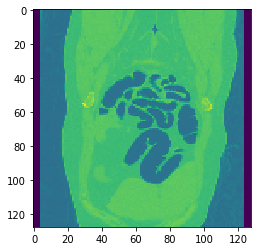

In [105]:
#original CT
lastNrrd=np.array(X_test)
print(np.shape(lastNrrd))
plt.imshow(lastNrrd[0,:,85,:,0])

(1, 128, 128, 128, 1)


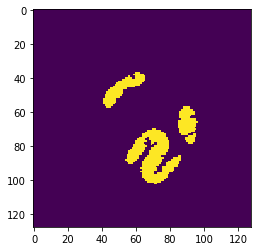

In [106]:
#human segmentation
lastSeg=np.array(y_test)
print(np.shape(lastSeg))
plt.imshow(lastSeg[0,:,85,:,0])

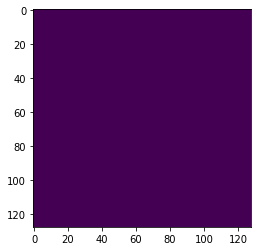

In [153]:
#Neural network segmentation converted to binary
plt.imshow(np.array(binaryOutputSeg[0,:,85,:,0]))

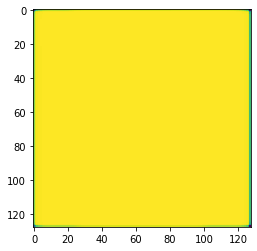

In [149]:
# output from running NN on X_test
# QUESTION
# how do I address the fact that it seems to be segmenting the entire image
# is this the fault of not enough samples? I thought the generator's aim was to fix that

plt.imshow(np.array(outputSeg[0,:,85,:,0]))

In [ ]:
plt.imshow(np.array(binaryOutputSegTest[0,:,85,:,0]))

In [ ]:
# output from running NN on y_test
#aka output segmentation before binarization
plt.imshow(np.array(outputSeg2[0,:,85,:,0]))

In [ ]:
import itk
#itk.Image.GetTypes()
floatBinaryOutputSeg = binaryOutputSeg.astype(np.float)
absBinaryOutputSeg = np.fabs(binaryOutputSeg)
timestamp3 = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
image = itk.GetImageFromArray(np.array(floatBinaryOutputSeg))
itk.imwrite(image, timestamp3+'.nrrd')